In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import multi_gpu_model

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_128_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=128, strides=1, padding='same', input_shape=input_shape)) 
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=128*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_128_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        768       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 128)        82048     
_________________________________________________________________
activation_1 (Activation)    (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5333, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
activation_18 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
activation_19 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 5333, 128)         0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 5333, 128)         82048     
_________________________________________________________________
activation_20 (Activation)   (None, 5333, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0150 - acc: 0.3691
Epoch 00001: val_loss improved from inf to 1.56676, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_3_conv_checkpoint/001-1.5668.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 2.0150 - acc: 0.3691 - val_loss: 1.5668 - val_acc: 0.5181
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3959 - acc: 0.5708
Epoch 00002: val_loss improved from 1.56676 to 1.40682, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_3_conv_checkpoint/002-1.4068.hdf5
36805/36805 [==============================] - 34s 926us/sample - loss: 1.3959 - acc: 0.5708 - val_loss: 1.4068 - val_acc: 0.5663
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1416 - acc: 0.6516
Epoch 00003: val_loss improved from 1.40682 to 1.35032, saving mode

36800/36805 [============================>.] - ETA: 0s - loss: 0.0690 - acc: 0.9826
Epoch 00028: val_loss did not improve from 1.30582
36805/36805 [==============================] - 35s 945us/sample - loss: 0.0690 - acc: 0.9826 - val_loss: 2.5582 - val_acc: 0.6031
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0616 - acc: 0.9848
Epoch 00029: val_loss did not improve from 1.30582
36805/36805 [==============================] - 35s 958us/sample - loss: 0.0616 - acc: 0.9848 - val_loss: 2.6144 - val_acc: 0.5975
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0631 - acc: 0.9851
Epoch 00030: val_loss did not improve from 1.30582
36805/36805 [==============================] - 35s 959us/sample - loss: 0.0631 - acc: 0.9851 - val_loss: 2.6090 - val_acc: 0.6031
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0620 - acc: 0.9855
Epoch 00031: val_loss did not improve from 1.30582
36805/36805 [==================

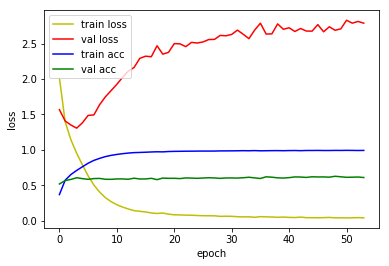

4815/4815 [==============================] - 7s 2ms/sample - loss: 1.3925 - acc: 0.5718
Loss: 1.3925352943772962 Accuracy: 0.57175493

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9255 - acc: 0.3836
Epoch 00001: val_loss improved from inf to 1.44310, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_4_conv_checkpoint/001-1.4431.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 1.9255 - acc: 0.3836 - val_loss: 1.4431 - val_acc: 0.5567
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3137 - acc: 0.5943
Epoch 00002: val_loss improved from 1.44310 to 1.22143, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_4_conv_checkpoint/002-1.2214.hdf5
36805/36805 [==============================] - 37s 993us/sample - loss: 1.3137 - acc: 0.5943 - val_loss: 1.2214 - val_acc: 0.6224
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1

36800/36805 [============================>.] - ETA: 0s - loss: 0.0705 - acc: 0.9789
Epoch 00028: val_loss did not improve from 0.95332
36805/36805 [==============================] - 37s 997us/sample - loss: 0.0705 - acc: 0.9789 - val_loss: 1.5112 - val_acc: 0.7417
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0644 - acc: 0.9809
Epoch 00029: val_loss did not improve from 0.95332
36805/36805 [==============================] - 37s 993us/sample - loss: 0.0644 - acc: 0.9809 - val_loss: 1.5497 - val_acc: 0.7377
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0629 - acc: 0.9815
Epoch 00030: val_loss did not improve from 0.95332
36805/36805 [==============================] - 36s 989us/sample - loss: 0.0629 - acc: 0.9815 - val_loss: 1.4980 - val_acc: 0.7419
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0618 - acc: 0.9818
Epoch 00031: val_loss did not improve from 0.95332
36805/36805 [==================

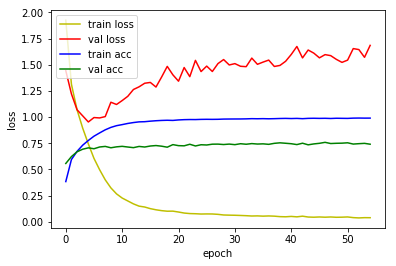

4815/4815 [==============================] - 7s 1ms/sample - loss: 1.0524 - acc: 0.6766
Loss: 1.0524171884928908 Accuracy: 0.6766355

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9222 - acc: 0.3773
Epoch 00001: val_loss improved from inf to 1.40916, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_5_conv_checkpoint/001-1.4092.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 1.9222 - acc: 0.3772 - val_loss: 1.4092 - val_acc: 0.5521
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2887 - acc: 0.6010
Epoch 00002: val_loss improved from 1.40916 to 1.08047, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_5_conv_checkpoint/002-1.0805.hdf5
36805/36805 [==============================] - 38s 1ms/sample - loss: 1.2886 - acc: 0.6010 - val_loss: 1.0805 - val_acc: 0.6823
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.04

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0788 - acc: 0.9760
Epoch 00028: val_loss did not improve from 0.68283
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0788 - acc: 0.9760 - val_loss: 0.9500 - val_acc: 0.8160
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0721 - acc: 0.9779
Epoch 00029: val_loss did not improve from 0.68283
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0721 - acc: 0.9779 - val_loss: 0.8424 - val_acc: 0.8276
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0690 - acc: 0.9788
Epoch 00030: val_loss did not improve from 0.68283
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0690 - acc: 0.9788 - val_loss: 0.9109 - val_acc: 0.8132
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0703 - acc: 0.9787
Epoch 00031: val_loss did not improve from 0.68283
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0391 - acc: 0.9905
Epoch 00058: val_loss did not improve from 0.68283
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0391 - acc: 0.9905 - val_loss: 0.9971 - val_acc: 0.8328
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9906
Epoch 00059: val_loss did not improve from 0.68283
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0378 - acc: 0.9906 - val_loss: 1.0208 - val_acc: 0.8451
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0405 - acc: 0.9887
Epoch 00060: val_loss did not improve from 0.68283
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.0405 - acc: 0.9888 - val_loss: 1.0046 - val_acc: 0.8421

1D_CNN_custom_ch_128_DO_5_conv Model


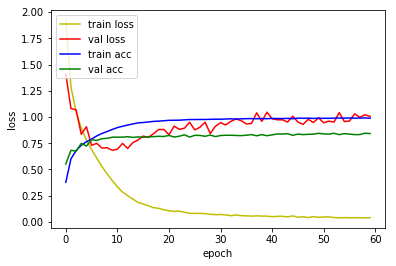

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.7859 - acc: 0.7701
Loss: 0.7858693222390528 Accuracy: 0.77009344

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9821 - acc: 0.3528
Epoch 00001: val_loss improved from inf to 1.36695, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_6_conv_checkpoint/001-1.3669.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 1.9820 - acc: 0.3528 - val_loss: 1.3669 - val_acc: 0.5805
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3300 - acc: 0.5779
Epoch 00002: val_loss improved from 1.36695 to 1.12111, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_6_conv_checkpoint/002-1.1211.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 1.3300 - acc: 0.5778 - val_loss: 1.1211 - val_acc: 0.6664
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1201 - acc: 0.9602
Epoch 00026: val_loss did not improve from 0.33986
36805/36805 [==============================] - 38s 1ms/sample - loss: 0.1201 - acc: 0.9602 - val_loss: 0.3835 - val_acc: 0.9150
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1160 - acc: 0.9624
Epoch 00027: val_loss did not improve from 0.33986
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.1159 - acc: 0.9625 - val_loss: 0.3789 - val_acc: 0.9117
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1079 - acc: 0.9651
Epoch 00028: val_loss did not improve from 0.33986
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.1079 - acc: 0.9651 - val_loss: 0.3905 - val_acc: 0.9110
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1040 - acc: 0.9668
Epoch 00029: val_loss did not improve from 0.33986
36805/36805 [===========

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0425 - acc: 0.9871
Epoch 00056: val_loss did not improve from 0.33986
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.0425 - acc: 0.9871 - val_loss: 0.4356 - val_acc: 0.9252
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0400 - acc: 0.9878
Epoch 00057: val_loss did not improve from 0.33986
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0400 - acc: 0.9878 - val_loss: 0.4822 - val_acc: 0.9159
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0450 - acc: 0.9866
Epoch 00058: val_loss did not improve from 0.33986
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.0450 - acc: 0.9866 - val_loss: 0.4559 - val_acc: 0.9236
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9882
Epoch 00059: val_loss did not improve from 0.33986
36805/36805 [===========

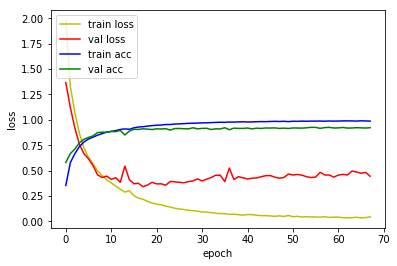

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.4116 - acc: 0.8802
Loss: 0.41161584854125977 Accuracy: 0.8801662

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0531 - acc: 0.3255
Epoch 00001: val_loss improved from inf to 1.30697, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_7_conv_checkpoint/001-1.3070.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 2.0530 - acc: 0.3255 - val_loss: 1.3070 - val_acc: 0.5980
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2685 - acc: 0.5896
Epoch 00002: val_loss improved from 1.30697 to 1.00844, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_7_conv_checkpoint/002-1.0084.hdf5
36805/36805 [==============================] - 39s 1ms/sample - loss: 1.2685 - acc: 0.5896 - val_loss: 1.0084 - val_acc: 0.6879
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1101 - acc: 0.9627
Epoch 00025: val_loss did not improve from 0.17599
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.1101 - acc: 0.9627 - val_loss: 0.1933 - val_acc: 0.9492
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1061 - acc: 0.9650
Epoch 00026: val_loss did not improve from 0.17599
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.1061 - acc: 0.9650 - val_loss: 0.1943 - val_acc: 0.9476
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1042 - acc: 0.9644
Epoch 00027: val_loss improved from 0.17599 to 0.17357, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_7_conv_checkpoint/027-0.1736.hdf5
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.1042 - acc: 0.9644 - val_loss: 0.1736 - val_acc: 0.9520
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 

36800/36805 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9863
Epoch 00054: val_loss did not improve from 0.17357
36805/36805 [==============================] - 39s 1ms/sample - loss: 0.0397 - acc: 0.9863 - val_loss: 0.2114 - val_acc: 0.9546
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0361 - acc: 0.9879
Epoch 00055: val_loss did not improve from 0.17357
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0361 - acc: 0.9879 - val_loss: 0.2268 - val_acc: 0.9576
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0309 - acc: 0.9895
Epoch 00056: val_loss did not improve from 0.17357
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0309 - acc: 0.9895 - val_loss: 0.2156 - val_acc: 0.9595
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9879
Epoch 00057: val_loss did not improve from 0.17357
36805/36805 [========================

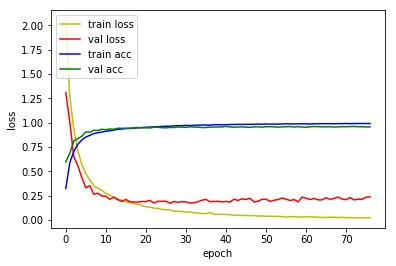

4815/4815 [==============================] - 7s 2ms/sample - loss: 0.2154 - acc: 0.9387
Loss: 0.21535514052783217 Accuracy: 0.9387331

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9251 - acc: 0.3698
Epoch 00001: val_loss improved from inf to 1.01605, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_8_conv_checkpoint/001-1.0160.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.9249 - acc: 0.3699 - val_loss: 1.0160 - val_acc: 0.6867
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9931 - acc: 0.6819
Epoch 00002: val_loss improved from 1.01605 to 0.63776, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_8_conv_checkpoint/002-0.6378.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.9930 - acc: 0.6819 - val_loss: 0.6378 - val_acc: 0.7997
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6

36800/36805 [============================>.] - ETA: 0s - loss: 0.0847 - acc: 0.9711
Epoch 00025: val_loss did not improve from 0.12018
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0847 - acc: 0.9711 - val_loss: 0.1338 - val_acc: 0.9613
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0788 - acc: 0.9734
Epoch 00026: val_loss improved from 0.12018 to 0.11179, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_8_conv_checkpoint/026-0.1118.hdf5
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0788 - acc: 0.9734 - val_loss: 0.1118 - val_acc: 0.9697
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0780 - acc: 0.9734
Epoch 00027: val_loss did not improve from 0.11179
36805/36805 [==============================] - 40s 1ms/sample - loss: 0.0780 - acc: 0.9734 - val_loss: 0.1222 - val_acc: 0.9690
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0699 - acc:

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0237 - acc: 0.9925
Epoch 00055: val_loss did not improve from 0.11179
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0237 - acc: 0.9925 - val_loss: 0.1411 - val_acc: 0.9681
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0280 - acc: 0.9906
Epoch 00056: val_loss did not improve from 0.11179
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0280 - acc: 0.9906 - val_loss: 0.1316 - val_acc: 0.9676
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9913
Epoch 00057: val_loss did not improve from 0.11179
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0260 - acc: 0.9913 - val_loss: 0.1454 - val_acc: 0.9693
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9911
Epoch 00058: val_loss did not improve from 0.11179
36805/36805 [===========

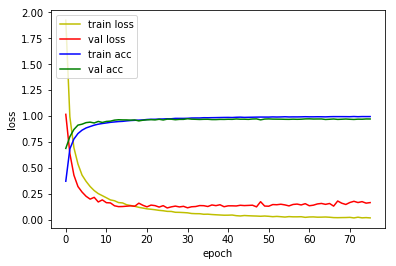

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.1628 - acc: 0.9543
Loss: 0.16284374764280032 Accuracy: 0.95430946

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6425 - acc: 0.4671
Epoch 00001: val_loss improved from inf to 0.81307, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_9_conv_checkpoint/001-0.8131.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 1.6425 - acc: 0.4671 - val_loss: 0.8131 - val_acc: 0.7321
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7607 - acc: 0.7514
Epoch 00002: val_loss improved from 0.81307 to 0.51611, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_9_conv_checkpoint/002-0.5161.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.7607 - acc: 0.7514 - val_loss: 0.5161 - val_acc: 0.8293
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9858
Epoch 00027: val_loss did not improve from 0.12534
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0420 - acc: 0.9858 - val_loss: 0.1442 - val_acc: 0.9632
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9867
Epoch 00028: val_loss did not improve from 0.12534
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0389 - acc: 0.9867 - val_loss: 0.1789 - val_acc: 0.9597
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0376 - acc: 0.9871
Epoch 00029: val_loss did not improve from 0.12534
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0376 - acc: 0.9871 - val_loss: 0.1621 - val_acc: 0.9646
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0339 - acc: 0.9889
Epoch 00030: val_loss did not improve from 0.12534
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0149 - acc: 0.9954
Epoch 00057: val_loss did not improve from 0.12534
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.0148 - acc: 0.9954 - val_loss: 0.1945 - val_acc: 0.9602
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0136 - acc: 0.9955
Epoch 00058: val_loss did not improve from 0.12534
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0136 - acc: 0.9955 - val_loss: 0.2080 - val_acc: 0.9655
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0146 - acc: 0.9957
Epoch 00059: val_loss did not improve from 0.12534
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.0146 - acc: 0.9957 - val_loss: 0.1959 - val_acc: 0.9665
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0149 - acc: 0.9955
Epoch 00060: val_loss did not improve from 0.12534
36805/36805 [===========

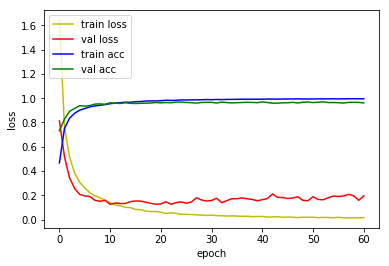

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.2026 - acc: 0.9396
Loss: 0.20258532717499034 Accuracy: 0.9395639



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_128_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_128_DO(conv_num=i)
        
    model = multi_gpu_model(model, gpus=4)
    
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_128_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_128_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_42_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
_______________________________________________________________________

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.4116 - acc: 0.8802
Loss: 0.41161584854125977 Accuracy: 0.8801662

1D_CNN_custom_ch_128_DO_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_60_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, 16000, 1)     0           conv1d_60_input[0][0]            
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, 16000, 1)     0           conv1d_60_input[0][0]            
__________________________________________________________________________________________________
lambda_18 (Lambda)              (Non

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_128_DO'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_128_DO_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_42_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 16000, 1)     0           conv1d_42_input[0][0]            
_______________________________________________________________________

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.4876 - acc: 0.9076
Loss: 0.4875690118731739 Accuracy: 0.9075805

1D_CNN_custom_ch_128_DO_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv1d_60_input (InputLayer)    (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
lambda_16 (Lambda)              (None, 16000, 1)     0           conv1d_60_input[0][0]            
__________________________________________________________________________________________________
lambda_17 (Lambda)              (None, 16000, 1)     0           conv1d_60_input[0][0]            
__________________________________________________________________________________________________
lambda_18 (Lambda)              (None